<a href="https://colab.research.google.com/github/21WH1A0427-Bhaavya/TeamUNO/blob/main/XGBoost%2BRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [159]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

import xgboost as xgb
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import gym
from gym import spaces

In [160]:
df = pd.read_csv("/content/enhanced_data.csv")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [119]:
df.columns

Index(['user_id', 'department', 'privilege_level', 'session_id', 'timestamp',
       'login_time', 'logout_time', 'session_minutes', 'device_type',
       'location_country', 'ip_address', 'remote_ip', 'remote_ip_type',
       'port_used', 'files_accessed', 'bytes_downloaded', 'direction',
       'app_used', 'file_sensitivity', 'sensitive_command', 'failed_logins',
       'mfa_used', 'time_risk', 'file_risk', 'geo_risk', 'app_risk',
       'auth_risk', 'risk_score', 'alert_priority', 'anomaly_score',
       'is_anomaly', 'anomaly_type'],
      dtype='object')

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39600 entries, 0 to 39599
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            39600 non-null  object 
 1   department         39600 non-null  object 
 2   privilege_level    39600 non-null  object 
 3   session_id         39600 non-null  object 
 4   timestamp          39600 non-null  object 
 5   login_time         39600 non-null  object 
 6   logout_time        39600 non-null  object 
 7   session_minutes    39600 non-null  int64  
 8   device_type        39600 non-null  object 
 9   location_country   39600 non-null  object 
 10  ip_address         39600 non-null  object 
 11  remote_ip          39600 non-null  object 
 12  remote_ip_type     39600 non-null  object 
 13  port_used          39600 non-null  int64  
 14  files_accessed     39600 non-null  int64  
 15  bytes_downloaded   39600 non-null  int64  
 16  direction          396

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [145]:
#Sessions
total_anomaly_sessions = (df['is_anomaly'] != 0).sum()
print("Total anomaly sessions:", total_anomaly_sessions)

#Unique users
anomalous_users = df.loc[df['is_anomaly'] != 0, 'user_id'].unique()
count_anomalous_users = len(anomalous_users)
print("Number of unique users with at least one anomaly:", count_anomalous_users)

Total anomaly sessions: 1980
Number of unique users with at least one anomaly: 120


In [146]:
#Feature Handling
df['mfa_used'] = df['mfa_used'].map({'No': 0, 'Yes': 1})
df['alert_priority'] = df['alert_priority'].map({'Low': 0, 'Medium': 1, 'High': 2})

if df['sensitive_command'].dtype == object:
    df['sensitive_command'] = df['sensitive_command'].map({'No': 0, 'Yes': 1})

# login_risk
df['hour'] = pd.to_datetime(df['login_time'], errors='coerce').dt.hour
df['weekday'] = pd.to_datetime(df['login_time'], errors='coerce').dt.weekday
df['login_risk'] = ((df['hour'] < 8) | (df['hour'] > 18) | (df['weekday'] >= 5)).astype(int)

# device_risk
device_col = 'device_type'
device_counts = df[device_col].value_counts(normalize=True)
df['device_risk'] = 1.0 - df[device_col].map(device_counts).fillna(0.0)
if df['device_risk'].max() > 0:
    df['device_risk'] = df['device_risk'] / df['device_risk'].max()
else:
    df['device_risk'] = 0.0

# weekend flag
df['day_risk'] = df['weekday'].apply(lambda x: 0.5 if x >= 5 else 0.0)

#command count
if 'command_count' not in df.columns:
    df['command_count'] = 0

#categorical encoding
label_encoders = {}
categorical_cols = [
    'privilege_level', 'device_type', 'direction', 'app_used',
    'file_sensitivity', 'anomaly_type', 'location_country']
for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  #for reverse-transform

features = [
    'privilege_level_encoded', 'session_minutes', 'files_accessed', 'bytes_downloaded',
    'device_type_encoded', 'location_country_encoded', 'port_used', 'app_used_encoded',
    'file_sensitivity_encoded', 'sensitive_command', 'failed_logins', 'command_count',
    'login_risk', 'device_risk', 'day_risk', 'mfa_used', 'direction_encoded',
    'time_risk', 'file_risk', 'geo_risk', 'app_risk', 'auth_risk',
    'alert_priority', 'anomaly_score', 'anomaly_type_encoded'
]

/tmp/ipython-input-4109520425.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['hour'] = pd.to_datetime(df['login_time'], errors='coerce').dt.hour
/tmp/ipython-input-4109520425.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['weekday'] = pd.to_datetime(df['login_time'], errors='coerce').dt.weekday
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [147]:
#Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])
y = df['is_anomaly'].astype(int).values

model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=50, use_label_encoder=False, eval_metric='logloss')
model.fit(X_scaled, y)

df['risk_score_xgb'] = model.predict_proba(X_scaled)[:, 1]

# top 10 Risky Sessions
df[['user_id', 'privilege_level', 'files_accessed', 'direction', 'bytes_downloaded',
        'app_used', 'risk_score_xgb', 'anomaly_type']].sort_values('risk_score_xgb', ascending=False).head(10)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:37:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,user_id,privilege_level,files_accessed,direction,bytes_downloaded,app_used,risk_score_xgb,anomaly_type
409,user_00103,user,11,Download,37158,excel,0.999381,exfiltration_external
31024,user_00107,user,6,Download,132740,excel,0.999381,failed_logins
34972,user_00114,user,11,Internal,55708,file_explorer,0.999379,failed_logins
2107,user_00005,developer,8,Download,134441,excel,0.999379,account_sharing
24973,user_00070,user,9,Internal,144785,excel,0.999379,mass_download
28216,user_00110,user,13,Download,215182,excel,0.999378,exfiltration_external
9723,user_00046,user,9,Download,94849,excel,0.999378,bot_activity
12994,user_00059,user,9,Upload,75734,excel,0.999378,file_sensitivity_violation
18025,user_00110,user,6,Download,88391,excel,0.999378,geo_impossible
31201,user_00029,user,11,Internal,69695,excel,0.999378,geo_impossible


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [149]:
print(np.unique(model.predict(X_scaled), return_counts=True))
print(np.unique(y, return_counts=True))


(array([0, 1]), array([37620,  1980]))
(array([0, 1]), array([37620,  1980]))


In [150]:
print(df[features].std())


privilege_level_encoded          0.442222
session_minutes                 60.045955
files_accessed                   2.922633
bytes_downloaded            153548.357616
device_type_encoded              1.432626
location_country_encoded         1.261623
port_used                     1102.314563
app_used_encoded                 2.476924
file_sensitivity_encoded         0.799413
sensitive_command                0.099624
failed_logins                    0.223259
command_count                    0.000000
login_risk                       0.250060
device_risk                      0.170600
day_risk                         0.000000
mfa_used                         0.272738
direction_encoded                0.667613
time_risk                        2.500601
file_risk                        4.828575
geo_risk                         2.657837
app_risk                         2.763412
auth_risk                        1.487728
alert_priority                   0.053343
anomaly_score                    0

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


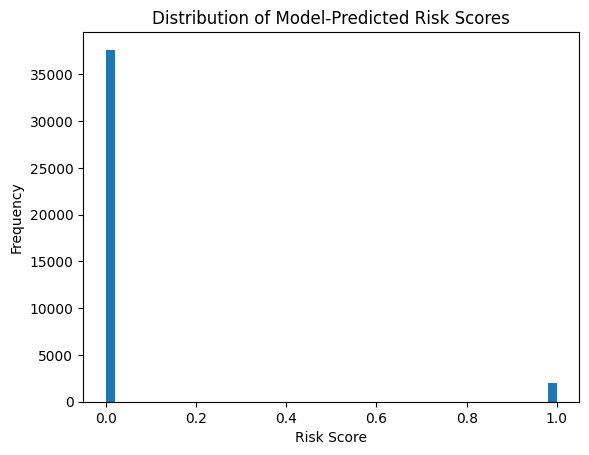

In [151]:
probas = model.predict_proba(X_scaled)[:, 1]
import matplotlib.pyplot as plt
plt.hist(probas, bins=50)
plt.title("Distribution of Model-Predicted Risk Scores")
plt.xlabel("Risk Score")
plt.ylabel("Frequency")
plt.show()

In [153]:
importances = model.feature_importances_
for name, importance in sorted(zip(features, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {importance*100}")

anomaly_type_encoded: 99.99920654296875
file_sensitivity_encoded: 0.00014710449613630772
files_accessed: 0.00013904544175602496
bytes_downloaded: 0.00011764570808736607
app_used_encoded: 9.810346818994731e-05
file_risk: 7.595912757096812e-05
session_minutes: 7.358531001955271e-05
port_used: 7.357733557000756e-05
anomaly_score: 6.163327634567395e-05
privilege_level_encoded: 0.0
device_type_encoded: 0.0
location_country_encoded: 0.0
sensitive_command: 0.0
failed_logins: 0.0
command_count: 0.0
login_risk: 0.0
device_risk: 0.0
day_risk: 0.0
mfa_used: 0.0
direction_encoded: 0.0
time_risk: 0.0
geo_risk: 0.0
app_risk: 0.0
auth_risk: 0.0
alert_priority: 0.0


In [124]:
#predictions on class labels
xgb_preds = model.predict(X_scaled)

#using your true labels
print("XGBoost Confusion Matrix on entire Data")
print(confusion_matrix(y, xgb_preds))
print("Classification Report:")
print(classification_report(y, xgb_preds))

XGBoost Confusion Matrix on entire Data
[[37620     0]
 [    0  1980]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37620
           1       1.00      1.00      1.00      1980

    accuracy                           1.00     39600
   macro avg       1.00      1.00      1.00     39600
weighted avg       1.00      1.00      1.00     39600



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [125]:
print("Confusion Matrix labels=[1,0]:")
print(confusion_matrix(y, xgb_preds, labels=[1,0]))

Confusion Matrix labels=[1,0]:
[[ 1980     0]
 [    0 37620]]


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [188]:
#high risk as top 10% risk_score_xgb
risk_thresh = df['risk_score_xgb'].quantile(0.9)
df['is_high_risk'] = (df['risk_score_xgb'] >= risk_thresh).astype(int)

#aggregation of app usage by all users and risky users
app_usage = df.groupby('app_used').agg(total_uses=('user_id', 'count'), high_risk_uses=('is_high_risk', 'sum')).reset_index()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


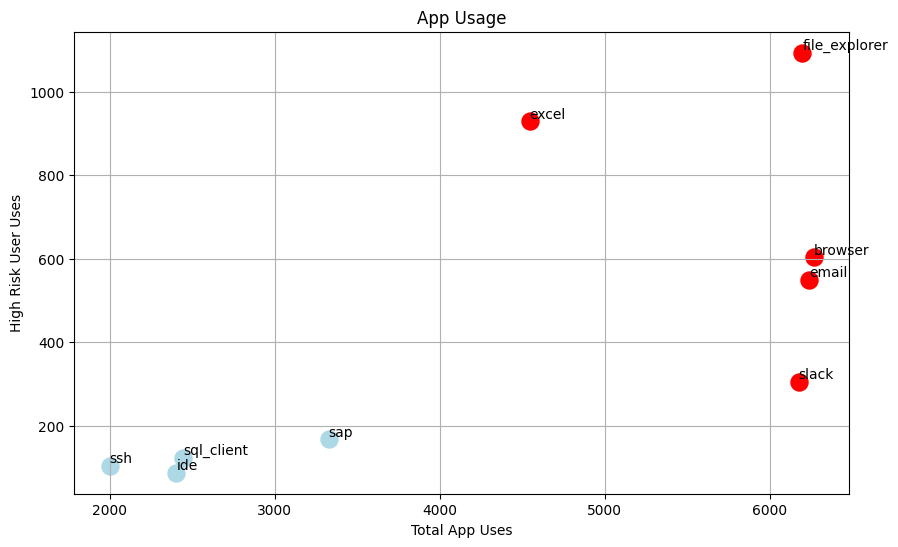

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [127]:
#scaling
scaler_apps = MinMaxScaler()
metrics_scaled = scaler_apps.fit_transform(app_usage[['total_uses', 'high_risk_uses']])

#clustering
kmeans = KMeans(n_clusters=2, random_state=42).fit(metrics_scaled)
app_usage['cluster'] = kmeans.labels_

#highest avg high-risk-users
red_cluster = app_usage.groupby('cluster')['high_risk_uses'].mean().idxmax()

plt.figure(figsize=(10, 6))
for i, row in app_usage.iterrows():
    color = 'red' if row['cluster'] == red_cluster else 'lightblue'
    plt.scatter(row['total_uses'], row['high_risk_uses'], s=150, color=color)
    plt.text(row['total_uses'], row['high_risk_uses'], row['app_used'], fontsize=10, ha='left', va='bottom')

plt.xlabel('Total App Uses')
plt.ylabel('High Risk User Uses')
plt.title('App Usage')
plt.grid(True)
plt.show()

In [129]:
class InsiderThreatEnv(gym.Env):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
        self.n_samples = X.shape[0]
        self.current = 0
        self.observation_space = spaces.Box(low=0, high=1, shape=(X.shape[1],), dtype=np.float32)
        self.action_space = spaces.Discrete(2)

    def reset(self):
        self.current = 0
        return self.X[self.current]

    def step(self, action):
        label = self.y[self.current]
        if action == 1 and label == 1: #TP
            reward = 2
        elif action == 1 and label == 0: #FP
            reward = -1
        elif action == 0 and label == 1: #FN
            reward = -3
        else:   #TN
            reward = 1
        self.current += 1
        done = self.current >= self.n_samples
        obs = self.X[self.current] if not done else np.zeros_like(self.X[0])
        return obs, reward, done, {}

    def render(self, mode='human'):
        pass

#Q-learning Agent
class QLearningAgent:
    def __init__(self, state_size, n_actions):
        self.q_table = np.zeros((10000, n_actions))
        self.n_actions = n_actions
        self.lr = 0.1
        self.gamma = 0.9
        self.epsilon = 0.2

    def get_state_idx(self, state):
      rounded = tuple(np.round(state[-4:] * 10).astype(int))
      idx = abs(hash(rounded)) % self.q_table.shape[0]
      return idx

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        idx = self.get_state_idx(state)
        return np.argmax(self.q_table[idx])

    def update(self, state, action, reward, next_state):
        idx = self.get_state_idx(state)
        next_idx = self.get_state_idx(next_state)
        best_next = np.max(self.q_table[next_idx])
        self.q_table[idx, action] += self.lr * (reward + self.gamma * best_next - self.q_table[idx, action])


In [130]:
env = InsiderThreatEnv(X_scaled, y)
agent = QLearningAgent(state_size=X_scaled.shape[1], n_actions=2)
n_episodes = 30

In [131]:
for episode in range(n_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state)
        state = next_state
        total_reward += reward
    print(f"Episode {episode+1}, Total Reward: {total_reward}")

Episode 1, Total Reward: 30084
Episode 2, Total Reward: 31483
Episode 3, Total Reward: 31943
Episode 4, Total Reward: 32173
Episode 5, Total Reward: 32505
Episode 6, Total Reward: 32655
Episode 7, Total Reward: 32371
Episode 8, Total Reward: 32383
Episode 9, Total Reward: 32810
Episode 10, Total Reward: 32597
Episode 11, Total Reward: 32621
Episode 12, Total Reward: 32999
Episode 13, Total Reward: 32289
Episode 14, Total Reward: 32471
Episode 15, Total Reward: 32773
Episode 16, Total Reward: 33112
Episode 17, Total Reward: 32546
Episode 18, Total Reward: 32840
Episode 19, Total Reward: 32975
Episode 20, Total Reward: 32801
Episode 21, Total Reward: 32861
Episode 22, Total Reward: 32945
Episode 23, Total Reward: 32900
Episode 24, Total Reward: 32910
Episode 25, Total Reward: 32865
Episode 26, Total Reward: 32573
Episode 27, Total Reward: 32776
Episode 28, Total Reward: 33168
Episode 29, Total Reward: 32717
Episode 30, Total Reward: 32913


In [132]:
rl_preds = [agent.select_action(s) for s in X_scaled]
print("RL Q-Learning Confusion Matrix")
print(confusion_matrix(y, rl_preds, labels=[1,0]))
print("Classification Report:")
print(classification_report(y, rl_preds))

RL Q-Learning Confusion Matrix
[[ 1731   249]
 [ 3764 33856]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     37620
           1       0.32      0.87      0.46      1980

    accuracy                           0.90     39600
   macro avg       0.65      0.89      0.70     39600
weighted avg       0.96      0.90      0.92     39600



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [133]:
top_users = df.groupby('user_id')['risk_score_xgb'].max().sort_values(ascending=False).head(10)
print(top_users)

user_id
user_00103    0.999381
user_00107    0.999381
user_00114    0.999379
user_00005    0.999379
user_00070    0.999379
user_00110    0.999378
user_00059    0.999378
user_00046    0.999378
user_00029    0.999378
user_00011    0.999378
Name: risk_score_xgb, dtype: float32


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [189]:
#high risk sessions flagged by risk_score, avgs, top 10 features that drive risk
risk_thresh = df['risk_score_xgb'].quantile(0.9)  # Or use your current risk score & method
df['is_high_risk'] = (df['risk_score_xgb'] >= risk_thresh).astype(int)
high_risk_df = df[df['is_high_risk'] == 1]

risk_drivers = high_risk_df[features].mean().sort_values(ascending=False)
print(risk_drivers.head(10))

bytes_downloaded            229401.432323
port_used                      849.894192
session_minutes                 59.614899
file_risk                        9.805846
files_accessed                   5.847475
app_used_encoded                 3.215152
device_type_encoded              2.780556
privilege_level_encoded          1.722727
location_country_encoded         1.719697
file_sensitivity_encoded         1.417677
dtype: float64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [177]:
df = pd.read_csv("/content/enhanced_data.csv")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [190]:
df['mfa_used'] = df['mfa_used'].map({'No': 0, 'Yes': 1})
df['alert_priority'] = df['alert_priority'].map({'Low': 0, 'Medium': 1, 'High': 2})
if 'sensitive_command' in df and df['sensitive_command'].dtype == object:
    df['sensitive_command'] = df['sensitive_command'].map({'No': 0, 'Yes': 1})

df['hour'] = pd.to_datetime(df['login_time'], errors='coerce').dt.hour
df['weekday'] = pd.to_datetime(df['login_time'], errors='coerce').dt.weekday
df['login_risk'] = ((df['hour'] < 8) | (df['hour'] > 18) | (df['weekday'] >= 5)).astype(int)
device_col = 'device_type'
device_counts = df[device_col].value_counts(normalize=True)
df['device_risk'] = 1.0 - df[device_col].map(device_counts).fillna(0.0)
if df['device_risk'].max() > 0:
    df['device_risk'] = df['device_risk'] / df['device_risk'].max()
else:
    df['device_risk'] = 0.0
df['day_risk'] = df['weekday'].apply(lambda x: 0.5 if x >= 5 else 0.0)
if 'command_count' not in df.columns:
    df['command_count'] = 0

label_encoders = {}
categorical_cols = [
    'privilege_level', 'device_type', 'direction', 'app_used',
    'file_sensitivity', 'location_country'
]
for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

#remove possible leaky ones:
leaky_features = ['anomaly_type_encoded', 'anomaly_score']
features = [
    'privilege_level_encoded', 'session_minutes', 'files_accessed', 'bytes_downloaded',
    'device_type_encoded', 'location_country_encoded', 'port_used', 'app_used_encoded',
    'file_sensitivity_encoded', 'sensitive_command', 'failed_logins', 'command_count',
    'login_risk', 'device_risk', 'day_risk', 'mfa_used', 'direction_encoded',
    'time_risk', 'file_risk', 'geo_risk', 'app_risk', 'auth_risk',
    'alert_priority'
]
features = [f for f in features if f not in leaky_features]

scaler = MinMaxScaler()
X = df[features].fillna(0).values
X_scaled = scaler.fit_transform(X)
y = df['is_anomaly'].astype(int).values

model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=50,
                         use_label_encoder=False, eval_metric='logloss', scale_pos_weight=len(y[y==0])/max(1,len(y[y==1])))
model.fit(X_scaled, y)

probas = model.predict_proba(X_scaled)[:, 1]
custom_threshold = 0.550
custom_preds = (probas > custom_threshold).astype(int)
print(confusion_matrix(y, custom_preds))
print(classification_report(y, custom_preds))

#Feature Importances
importances = model.feature_importances_
feat_imp = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)
print("\nXGBoost feature importances (no leakage):")
for name, importance in feat_imp:
    print(f"{name}: {importance*100:.3f}")

/tmp/ipython-input-1613101053.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['hour'] = pd.to_datetime(df['login_time'], errors='coerce').dt.hour
/tmp/ipython-input-1613101053.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['weekday'] = pd.to_datetime(df['login_time'], errors='coerce').dt.weekday
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarni

[[33293  4327]
 [  511  1469]]
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     37620
           1       0.25      0.74      0.38      1980

    accuracy                           0.88     39600
   macro avg       0.62      0.81      0.66     39600
weighted avg       0.95      0.88      0.90     39600


XGBoost feature importances (no leakage):
bytes_downloaded: 6.329
file_risk: 6.270
device_type_encoded: 6.140
app_used_encoded: 6.091
privilege_level_encoded: 5.791
session_minutes: 5.766
auth_risk: 5.687
port_used: 5.651
location_country_encoded: 5.602
failed_logins: 5.580
file_sensitivity_encoded: 5.448
direction_encoded: 5.437
files_accessed: 5.425
geo_risk: 5.359
device_risk: 5.340
app_risk: 4.964
login_risk: 4.906
sensitive_command: 4.214
command_count: 0.000
day_risk: 0.000
mfa_used: 0.000
time_risk: 0.000
alert_priority: 0.000


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


SHAP quantifies every sample, how much each feature pushes a prediction higher or lower compared to average model output. Which feature explain why model calls high or low risk.

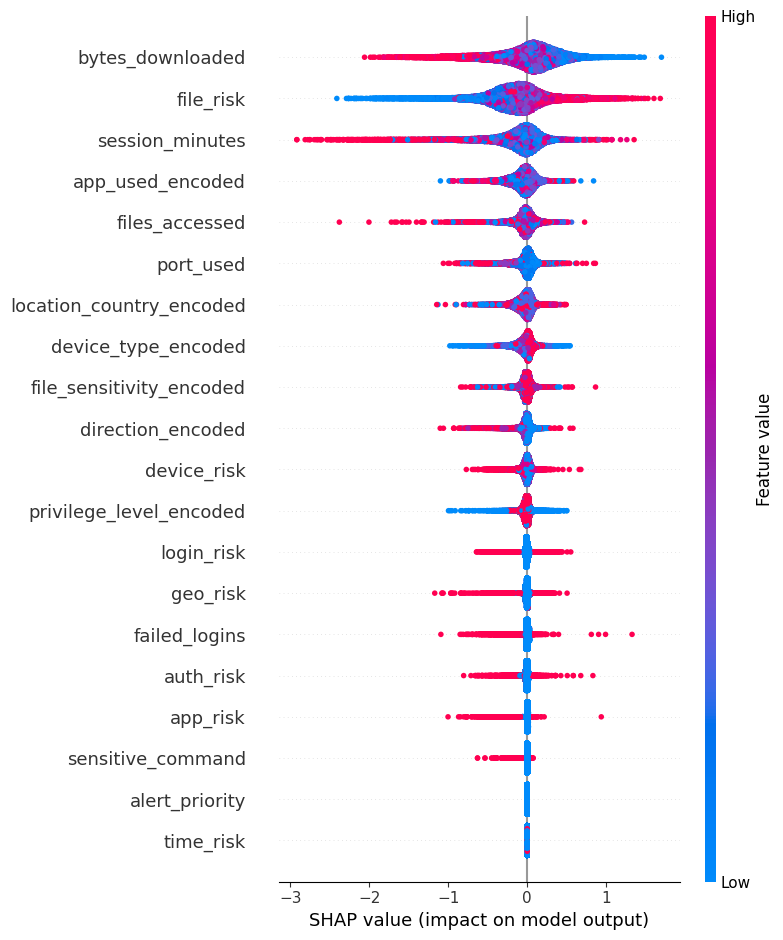

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [191]:
#SHAP reasoning
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_scaled)
shap.summary_plot(shap_values, X_scaled, feature_names=features)

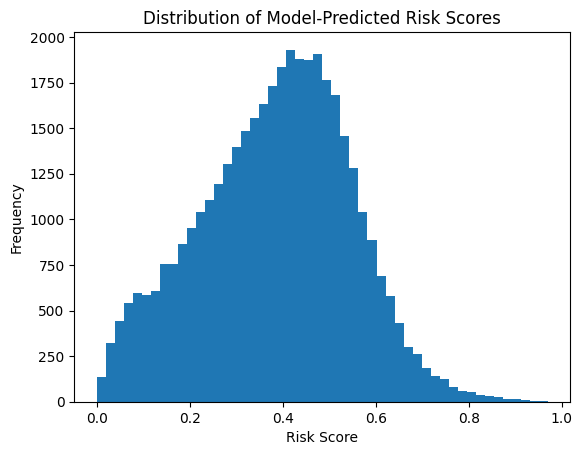

In [192]:
#probability Distribution
probas = model.predict_proba(X_scaled)[:, 1]
plt.hist(probas, bins=50)
plt.title("Distribution of Model-Predicted Risk Scores")
plt.xlabel("Risk Score")
plt.ylabel("Frequency")
plt.show()